In [1]:
import os
import sys
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import math
import scipy.stats as stats


import import_ipynb
from CustomDataset import ControlsDataset
from Model import ConvNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print('using device', device)

importing Jupyter notebook from CustomDataset.ipynb
importing Jupyter notebook from Model.ipynb
using device cpu


In [2]:
torch.cuda.empty_cache()

In [3]:
dataset = ControlsDataset()
dataset.labels.num_categories = 21
dataset.labels.transform.categorize(1.05, -1.05, 21)
dataset.images.set_grayscale(False)
print("Data size", len(dataset.labels))
dataset.make_dataloaders()

Data size 1101
Total training stacks 7
Total validation stacks 2


In [4]:
net = ConvNet(color_channels = 3, outputs = 14, dataset = dataset).to(device)
#net = ConvNet(color_channels = 1, outputs = 21, dataset = dataset).to(device)
print("number of parameters: ", sum(p.numel() for p in net.parameters()))

units after conv 320
conv parameters:  32544
fc parameters:  65374
number of parameters:  97918


        ID  Angle  Category
0        0    0.0        10
1        1    0.0        10
2        2    0.0        10
3        3    0.0        10
4        4    0.0        10
...    ...    ...       ...
1096  1096    0.0        10
1097  1097    0.0        10
1098  1098    0.0        10
1099  1099    0.0        10
1100  1100    0.0        10

[1101 rows x 3 columns]
[ 54   9   3   7   6  16  34  38  46  86 764  22   4  12]
14


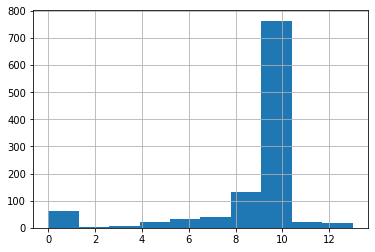

In [5]:
print(dataset.labels.dataframe)
counts = dataset.labels.dataframe.groupby('Category')['ID'].count()
array = np.array(counts)
print(array)
print(len(array))
dataset.labels.histogram()
# weights = max(counts)/array
# weights = torch.Tensor(weights).to(device)
# print(weights)
ratio = max(counts)/array



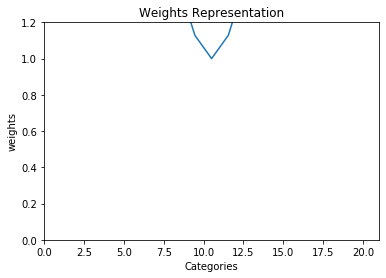

tensor([ 14.1481,  84.8889, 254.6667, 109.1429, 127.3333,  47.7500,  22.4706,
         20.1053,  16.6087,   8.8837,   1.0000,  34.7273, 191.0000,  63.6667])


In [6]:
mu, variance = 10.5, 4
sigma = math.sqrt(variance) 
x = np.linspace(0, 21, 21)
pdf = stats.norm.pdf(x, mu, sigma)
inv = ((np.ones(len(x)) * (max(pdf))) - pdf)/max(pdf) + 1

plt.xlim([0,21])
plt.ylim([0,1.2])
plt.plot(x, inv)
plt.title("Weights Representation")
plt.xlabel("Categories")
plt.ylabel("weights")
plt.show()

weights = ratio
weights = torch.Tensor(weights).to(device)
print(weights)

In [7]:
from scipy.stats import uniform

uniform.cdf([0, 1, 2, 3, 4, 5], loc=1, scale=4)

array([0.  , 0.  , 0.25, 0.5 , 0.75, 1.  ])

In [8]:
epochs = 30
optimizer = optim.Adam(net.parameters(), lr=0.0001)
print(type(weights))
criterion = nn.CrossEntropyLoss(weight=weights) # Changed from Mean-Squared to Cross-Entropy
#criterion = nn.MSELoss()
net.report_period = 20

net.optimizer = optimizer
#net.load("snapshots/1.217_model.pt")

net.fit(device,epochs,optimizer,criterion)

<class 'torch.Tensor'>


saved to tensorboard



KeyboardInterrupt: 

In [ ]:
# End of training Validation Test
#net.load("snapshots/0.727_model.pt")
#total, correct = net.score(device,dataset, "categorical")

total = 0
correct = 0
for i_batch, sampled_batch in enumerate(dataset.validloader):
    images = sampled_batch['image'].to(device).float()
    controls = sampled_batch['control'].to(device).long()
    controls = torch.flatten(controls)
    prediction = net(images)

    maximum = torch.argmax(prediction,dim = 1)
    print(maximum)
    print(controls)
    shared = maximum == controls
    shared = 1 * shared
    correct += int(torch.sum(shared))
    total += len(controls)

print("{:.1f}% classified correctly".format(100*correct/total))

In [ ]:
# Beginning of training Validation Test
net.load("snapshots/3.002_model.pt")
total, correct = net.score(device,dataset, "categorical")
print("{:.1f}% classified correctly".format(100*correct/total))

In [ ]:
# Function to compute adversarial noise given a trained net 
def compute_noise(net, lr, data_sample):
    input_img = data_sample['image'].to(device).float()
    control = data_sample['control'].to(device).long()
    
    # remember grad for image for adversarial attack
    input_img.requires_grad = True

    # pass img through the net 
    output = net(input_img)
    pred = torch.argmax(output, dim = 1)
    if pred != control:
        # nothing to fool if prediction aint right in the first place  
        return 0

    loss = F.nll_loss(output, control)
    # zero out gradients
    model.zero_grad()
    loss.backward()

    # get all the gradient data for computing adversarial noise 
    grads = input_img.grad.data

    # get element-wise sign of grad data
    # idk the tutorial did this: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
    grads_signs = grads.sign()

    # create adversarial noise
    adv_noise = lr*grads_signs

    # compute adverarial image by adding noise to input image
    adv_input = input_img + adv_noise

    # run net on adv_image and see if we succeded in fooling it 
    adv_output = net(adv_input)
    adv_pred = torch.argmax(adv_output, dim = 1)
    if adv_pred == control:
        # adv attack failed, either net is good or my code is bad 
        return -1
    else:
        return adv_noise, adv_input, pred, adv_pred, control


In [ ]:
torch.cuda.empty_cache()

In [ ]:
#Additional Info when using cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024))